In [1]:
from jaxtyping import ArrayLike
from flowjax.bijections.bijection import AbstractBijection
from flowjax.distributions import AbstractDistribution
import inspect
import jax.random as jr
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
import warnings

from frugal_flows.causal_flows import (
    train_frugal_flow,
)

from frugal_flows.bijections import UnivariateNormalCDF, LocCond

from frugal_flows.sample_outcome import sample_outcome

jax.config.update("jax_enable_x64", True)

In [2]:
keys = jr.split(jr.PRNGKey(8), 50)

In [3]:

N = 10000

z = jr.multivariate_normal(keys[0], jnp.array([0.,0.]), jnp.array([[1., 0],[0, 1.]]), shape=(N,))


x = jnp.expand_dims(jnp.hstack([jnp.ones(int(N/2))*0, jnp.ones(int(N/2))*1]),axis=1)
y = jax.random.normal(keys[2], shape=(N,1)) + x + jnp.expand_dims(z.sum(1), axis=1)

u_z = jax.scipy.stats.norm.cdf(z, loc=0, scale=1)

In [20]:
frugal_flow, losses = train_frugal_flow(
    key = jr.PRNGKey(9),
    y=y,
    u_z=u_z,  # impose discrete
    RQS_knots= 8,
    nn_depth= 1,
    nn_width= 50,
    flow_layers= 5,
    learning_rate= 5e-2,
    max_epochs= 500,
    max_patience = 50,
    batch_size = 1000,
    condition=x,
    mask_condition=True,
    causal_model = 'location_translation',
    causal_model_args={'RQS_knots':8, 'flow_layers':5, 'nn_width':50, 'nn_depth':2, 'ate':5.},
)

 29%|██████████████████████▊                                                       | 146/500 [01:31<03:41,  1.60it/s, train=1.4345362236445558, val=1.4825072776609831 (Max patience reached)]


In [21]:
frugal_flow.bijection[-1].bijections[0].ate

Array(1.03780964, dtype=float64)

In [5]:
def logistic_outcome(u_y: ArrayLike, 
                           ate: float, 
                           causal_condition: ArrayLike, 
                           const: float):
    def get_y(u_y, ate, x, const):
        p = jax.nn.sigmoid(ate*x + const)
        return (u_y>=p).astype(int)
    return jax.vmap(get_y, in_axes=(0, None, 0, None))(u_y, ate, causal_condition, const)

In [6]:
def causal_cdf_outcome(u_y: ArrayLike,
                       causal_cdf: AbstractBijection,
                       frugal_flow: AbstractDistribution,
                       causal_condition: ArrayLike,
                       **treatment_kwargs: dict,
    
    ):
                       

    causal_cdf_init_params = [i for i in inspect.signature(causal_cdf.__init__).parameters.keys() if ((i != 'self') and (i != 'cond_dim'))]
    for param in causal_cdf_init_params:
        if param not in treatment_kwargs.keys():
            treatment_kwargs[param] = None

    for k,v in treatment_kwargs.items():
        if k != 'cond_dim':
            if v is None:
                try:
                    treatment_kwargs[k] = getattr(frugal_flow.bijection.bijections[-1].bijection.bijections[0], k)
                except:
                    pass

    causal_cdf_simulate = causal_cdf(**treatment_kwargs)
    samples = jax.vmap(causal_cdf_simulate.inverse)(u_y, causal_condition)
    return samples, causal_cdf_simulate

In [7]:
def location_translation_outcome(u_y: ArrayLike,
                       frugal_flow: AbstractDistribution,
                       causal_condition: ArrayLike,
                       flow_condition: ArrayLike,
                       **treatment_kwargs: dict,
    
    ):

    causal_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[3].bijections[0].transform)(u_y[:,None], flow_condition)
    causal_reals = jax.vmap(frugal_flow.bijection.bijections[4].bijections[0].transform)(causal_minus1_plus1.flatten(), flow_condition)
        
    loc_cond_cdf_simulate = LocCond(**treatment_kwargs)
    samples = jax.vmap(loc_cond_cdf_simulate.transform)(causal_reals, causal_condition)
    return samples


In [8]:
def sample_outcome(frugal_flow: AbstractDistribution,
            affine_to_standard:bool,
             key: jr.PRNGKey,
            n_samples: float,
            causal_model: str,
            causal_condition: ArrayLike|None = None,
            causal_cdf: AbstractBijection|None = UnivariateNormalCDF,       
            **treatment_kwargs: dict):

    valid_causal_models = ['logistic_regression', 'causal_cdf', 'location_translation']
    flow_dim = frugal_flow.shape[0]

    if frugal_flow.cond_shape is None:
        flow_fake_condition = None
    else:    
       flow_fake_condition = jnp.ones((n_samples,frugal_flow.cond_shape[0]))
    
    uni_standard = jr.uniform(key, shape=(n_samples, flow_dim))
    uni_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[0].tree.transform)(uni_standard)

    corruni_minus1_plus1 = jax.vmap(frugal_flow.bijection.bijections[1].transform)(uni_minus1_plus1, flow_fake_condition)
    corruni = jax.vmap(frugal_flow.bijection.bijections[2].tree.transform)(corruni_minus1_plus1, flow_fake_condition)
    corruni_y = corruni[:,0]
    if affine_to_standard:
        if ((corruni_y.min()>=0.)&(corruni_y.max()<=1.)):
            warnings.warn(f"You have activated affine_to_standard but transformed variable was already between 0 and 1")
        corruni_standard = (corruni_y/2)+0.5
    else:
        corruni_standard = corruni_y

    if causal_model == 'logistic_regression':
        outcome_samples = logistic_outcome(u_y=corruni_standard, causal_condition=causal_condition, **treatment_kwargs)

    elif causal_model == 'causal_cdf':
        outcome_samples, _ = causal_cdf_outcome(u_y=corruni_standard, 
                                             causal_condition=causal_condition, 
                                             frugal_flow=frugal_flow,
                                             causal_cdf=causal_cdf,
                                             **treatment_kwargs)
        
    elif causal_model == 'location_translation':
        outcome_samples = location_translation_outcome(u_y=corruni_standard, 
                                           causal_condition=causal_condition, 
                                           flow_condition=flow_fake_condition,
                                           frugal_flow=frugal_flow,
                                           **treatment_kwargs)
    else:
        raise ValueError(f"Invalid choice. Please choose from: {valid_causal_models}")

    return outcome_samples
        


In [9]:
key= jr.PRNGKey(9),
n_samples=1000
causal_cdf=UnivariateNormalCDF, 
causal_condition= jnp.hstack([jnp.ones(int(n_samples/2))*0, jnp.ones(int(n_samples/2))*1]).astype(int)

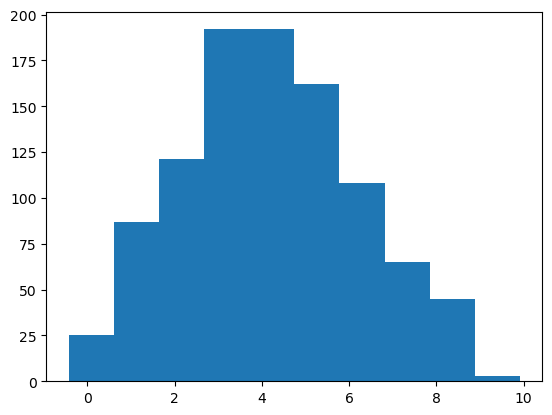

In [10]:
treatment_kwargs={'ate':5} #, 'const':0., 'scale':1.}
my_outcome = sample_outcome(frugal_flow=frugal_flow,
             key=keys[9],
            n_samples=n_samples,
            causal_model='location_translation',
            causal_condition=causal_condition, 
            affine_to_standard=False,
            **treatment_kwargs)

plt.hist(my_outcome);

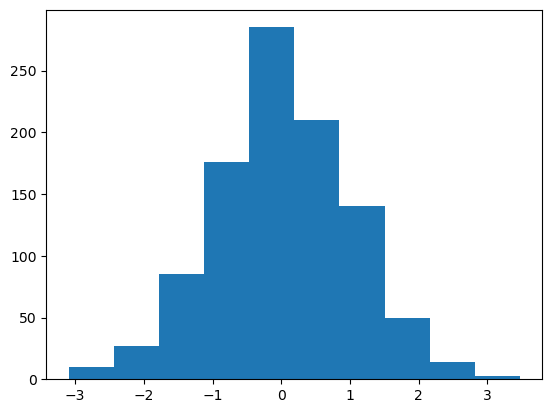

In [11]:
treatment_kwargs={'ate':5, 'const':0., 'scale':1.}
my_outcome  = sample_outcome(frugal_flow=frugal_flow,
             key=keys[9],
            n_samples=n_samples,
            causal_model='causal_cdf',
            causal_cdf=UnivariateNormalCDF,
            causal_condition=causal_condition,  
            affine_to_standard=True,
            **treatment_kwargs)

plt.hist(my_outcome);

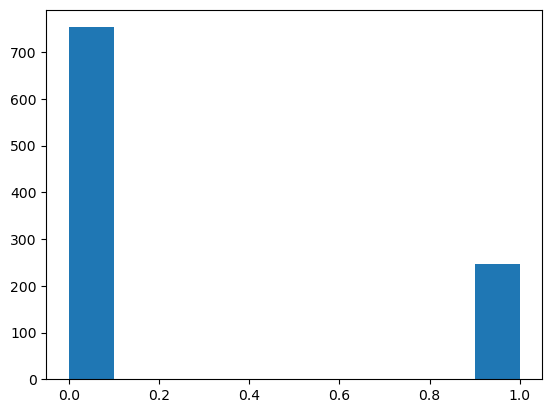

In [12]:
treatment_kwargs={'ate':5, 'const':0.}
my_outcome = sample_outcome(frugal_flow=frugal_flow,
             key=keys[9],
            n_samples=n_samples,
            causal_model='logistic_regression',
            causal_cdf=UnivariateNormalCDF,
            causal_condition=causal_condition,  
            affine_to_standard=True,
            **treatment_kwargs)

plt.hist(my_outcome);